In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_y.h5
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_valid_y.h5
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_valid_meta.csv
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_valid_x.h5
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_mask.h5
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_meta.csv
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_test_y.h5
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_test_meta.csv
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_test_x.h5
/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_x.h5-001/camelyonpatch_level_2_split_train_x.h5


In [2]:
# Core
import os
import time
import random
import yaml
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

# Metrics
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)


In [3]:
import yaml

config = {
    "seed": 1337,
    "n_seeds": 3,
    "device": "cuda:0",
    "deterministic": True,

    "data": {
        "dataset_version": "pcam_v1",
        "splits_file": "splits/patient_level_fold0.json",
        "img_size": 128,
        "normalize": {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]},
        "decode": "pillow_rgb",
        "stain_norm": "none",
        "augment": {
            "train": [
                {"hflip": 0.5},
                {"vflip": 0.5},
                {"color_jitter": {"b": 0.2, "c": 0.2, "s": 0.2}},
                {"blur": {"p": 0.2, "k": 3}},
            ],
            "val": []
        },
        "sampler": "random",
        "samples_per_epoch": None,
    },

    "loader": {
        "batch_size": 64,
        "grad_accum": 1,
        "num_workers": 4,
        "pin_memory": True,
        "persistent_workers": True,
    },

    "model": {
        "backbone": "densenet121",
        "weights": "imagenet_v1",
        "precision": "fp32",
        "dropout": 0.0,
        "freeze_backbone": False,
    },

    "objective": {
        "loss": "bce_logits",
        "pos_weight": None,
        "label_smoothing": 0.0,
        "focal": {"enable": False, "alpha": 0.25, "gamma": 2.0},
        "clip_grad_norm": None,
        "calibration": {"enable": False},
        "decision_threshold": 0.5,
        "tta": {"enable": False},
    },

    "optim": {
        "name": "adamw",
        "lr": 3.0e-4,
        "weight_decay": 1.0e-4,
        "betas": [0.9, 0.999],
        "schedule": "cosine",
        "t_max": 30,
        "warmup_steps": 0,
        "epochs": 10,
        "ema": {"enable": False, "decay": 0.999},
    },

    "eval": {
        "metrics": ["roc_auc", "pr_auc", "acc", "f1"],
        "ci_bootstrap": 2000,
        "select_best_by": "roc_auc",
        "eval_every": "epoch",
    },

    "env": {
        "torch": "2.3.1",
        "torchvision": "0.18.1",
        "cuda": "12.1",
        "cudnn_deterministic": True,
        "cublas_workspace": ":4096:8",
    }
}

# Save to YAML
with open("experiment.yaml", "w") as f:
    yaml.dump(config, f, sort_keys=False)

print("✅ experiment.yaml file created")

✅ experiment.yaml file created


In [4]:
import random, numpy as np, torch

with open("experiment.yaml", "r") as f:
    cfg = yaml.safe_load(f)

# -----------------------------
# Seed & Determinism
# -----------------------------
def set_seed(seed: int, deterministic: bool = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

set_seed(cfg["seed"], cfg["deterministic"])

# -----------------------------
# Device
# -----------------------------
device = torch.device(cfg["device"] if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


In [5]:
from torch.utils.data import Dataset
# --------------------------------
# Chunked Dataset for Memory Efficiency
# --------------------------------
class PCamDatasetChunk(Dataset):
    def __init__(self, h5_path, labels_path=None, transform=None, start_idx=0, end_idx=None):
        """
        h5_path: path to HDF5 file with images
        labels_path: path to HDF5 file with labels
        transform: torchvision transforms
        start_idx, end_idx: slice of the dataset to load (for splitting)
        """
        self.h5_path = h5_path
        self.labels_path = labels_path
        self.transform = transform
        
        # Open HDF5 files and slice the dataset
        self.h5_file = h5py.File(h5_path, "r")
        key = "x" if "x" in self.h5_file else list(self.h5_file.keys())[0]
        
        if end_idx is None:
            end_idx = len(self.h5_file[key])
            
        self.start_idx = start_idx
        self.end_idx = end_idx
        self.length = end_idx - start_idx
        
        # Memory-map the selected chunk
        self.images = self.h5_file[key][start_idx:end_idx]
        
        # Load labels
        self.labels = None
        if labels_path is not None:
            with h5py.File(labels_path, "r") as f:
                self.labels = f["y"][start_idx:end_idx]
        
        print(f"Dataset chunk initialized: samples {start_idx} to {end_idx} ({self.length} total)")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img = self.images[idx]
        img = Image.fromarray(img)
        
        if self.transform:
            img = self.transform(img)
            
        if self.labels is not None:
            label = int(self.labels[idx].item())
            return img, label
        else:
            return img

    def close(self):
        if hasattr(self, 'h5_file') and self.h5_file:
            self.h5_file.close()


In [6]:
# --------------------------------
# Transforms from Config
# --------------------------------
cfg_data = cfg["data"]

train_transform = transforms.Compose([
    transforms.Resize((cfg_data["img_size"], cfg_data["img_size"])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=cfg_data["normalize"]["mean"], 
                        std=cfg_data["normalize"]["std"])
])

val_transform = transforms.Compose([
    transforms.Resize((cfg_data["img_size"], cfg_data["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=cfg_data["normalize"]["mean"], 
                        std=cfg_data["normalize"]["std"])
])

# --------------------------------
# Dataset Paths
# --------------------------------
h5_train_x = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_x.h5-001/camelyonpatch_level_2_split_train_x.h5"
h5_train_y = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_train_y.h5"
h5_val_x   = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_valid_x.h5"
h5_val_y   = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_valid_y.h5"

# Get total training samples
with h5py.File(h5_train_x, "r") as f:
    total_train = len(f["x"])
    print(f"Total training samples: {total_train}")

# Split training data into chunks to manage memory
num_chunks = 4  # Split into 4 chunks (~65K samples each)
chunk_size = total_train // num_chunks
train_splits = []

for i in range(num_chunks):
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size if i < num_chunks - 1 else total_train
    train_splits.append((start_idx, end_idx))

print(f"Training data split into {num_chunks} chunks:")
for i, (start, end) in enumerate(train_splits):
    print(f"  Chunk {i+1}: samples {start} to {end} ({end-start} samples)")


Total training samples: 262144
Training data split into 4 chunks:
  Chunk 1: samples 0 to 65536 (65536 samples)
  Chunk 2: samples 65536 to 131072 (65536 samples)
  Chunk 3: samples 131072 to 196608 (65536 samples)
  Chunk 4: samples 196608 to 262144 (65536 samples)


In [7]:
# --------------------------------
# Create Validation Dataset
# --------------------------------
print("\nCreating validation dataset...")
val_dataset = PCamDatasetChunk(h5_val_x, labels_path=h5_val_y, transform=val_transform)

cfg_loader = cfg["loader"]
val_loader = DataLoader(
    val_dataset, 
    batch_size=cfg_loader["batch_size"], 
    shuffle=False, 
    num_workers=cfg_loader["num_workers"], 
    pin_memory=cfg_loader["pin_memory"]
)

print(f"Validation dataset created: {len(val_dataset)} samples, {len(val_loader)} batches")


Creating validation dataset...
Dataset chunk initialized: samples 0 to 32768 (32768 total)
Validation dataset created: 32768 samples, 512 batches


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import types

# -------------------------------
# GeM pooling (no in-place ops)
# -------------------------------
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)  # learnable exponent
        self.eps = eps

    def forward(self, x):
        # clamp -> pow -> global avg pool -> inverse pow
        x = torch.clamp(x, min=self.eps)
        x = torch.pow(x, self.p)
        x = F.avg_pool2d(x, kernel_size=(x.size(-2), x.size(-1)))
        x = torch.pow(x + self.eps, 1.0 / self.p)
        return x

    def __repr__(self):
        return f"{self.__class__.__name__}(p={self.p.data.tolist()[0]:.4f}, eps={self.eps})"

# --------------------------------
# Model Setup
# --------------------------------
cfg_model = cfg["model"]
print("Creating model...")

if cfg_model["backbone"] == "densenet121":
    if cfg_model["weights"] == "imagenet_v1":
        model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
    else:
        model = models.densenet121(weights=None)
else:
    raise NotImplementedError(f"Backbone {cfg_model['backbone']} not implemented")

# number of features stays the same as DenseNet's classifier input
num_features = model.classifier.in_features

# 1) Disable all in-place ReLUs to avoid autograd versioning issues
for m in model.modules():
    if isinstance(m, nn.ReLU):
        m.inplace = False

# 2) Attach GeM as a module and override forward to use it
model.gem = GeM()

def forward_with_gem(self, x):
    # torchvision DenseNet forward, but replace the AdaptiveAvgPool2d with GeM
    features = self.features(x)                # conv blocks
    out = F.relu(features, inplace=False)      # explicitly non-inplace
    out = self.gem(out)                        # global pooling via GeM
    out = torch.flatten(out, 1)
    out = self.classifier(out)
    return out

# monkey-patch forward
model.forward = types.MethodType(forward_with_gem, model)

# Replace the classifier as per your config
model.classifier = nn.Sequential(
    nn.Dropout(cfg_model["dropout"]),
    nn.Linear(num_features, 1)
)

# Send to device
model = model.to(device)

# Optionally freeze backbone
if cfg_model.get("freeze_backbone", False):
    for param in model.features.parameters():
        param.requires_grad = False
    print("Backbone frozen")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ Model created - Total params: {total_params:,}, Trainable: {trainable_params:,}")


Creating model...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 183MB/s]


✅ Model created - Total params: 6,954,882, Trainable: 6,954,882


In [9]:
# --------------------------------
# Training Setup
# --------------------------------
cfg_objective = cfg["objective"]
cfg_optim = cfg["optim"]

criterion = nn.BCEWithLogitsLoss()
decision_threshold = cfg_objective["decision_threshold"]

optimizer = optim.AdamW(
    model.parameters(),
    lr=cfg_optim["lr"],
    weight_decay=cfg_optim["weight_decay"],
    betas=tuple(cfg_optim["betas"])
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=cfg_optim["t_max"]
) if cfg_optim["schedule"].lower() == "cosine" else None

print("✅ Training setup complete")

✅ Training setup complete


In [10]:
import gc
# --------------------------------
# Training Loop
# --------------------------------
epochs = cfg_optim["epochs"]
train_losses = []
val_losses = []
roc_aucs = []
pr_aucs = []
accs = []
f1s = []

print(f"\n{'='*60}")
print("STARTING CHUNKED TRAINING")
print(f"{'='*60}")
print(f"Epochs: {epochs}, Chunks per epoch: {num_chunks}")

total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f"\n{'='*50}")
    print(f"EPOCH {epoch+1}/{epochs}")
    print(f"{'='*50}")
    
    # Training phase - iterate through chunks
    model.train()
    epoch_train_loss = 0.0
    epoch_train_samples = 0
    
    for chunk_idx, (start_idx, end_idx) in enumerate(train_splits):
        chunk_start_time = time.time()
        print(f"\nTraining on chunk {chunk_idx+1}/{num_chunks}: samples {start_idx} to {end_idx}")
        
        # Create dataset for this chunk
        train_dataset = PCamDatasetChunk(
            h5_train_x, 
            labels_path=h5_train_y,
            transform=train_transform,
            start_idx=start_idx,
            end_idx=end_idx
        )
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=cfg_loader["batch_size"],
            shuffle=True, 
            num_workers=cfg_loader["num_workers"], 
            pin_memory=cfg_loader["pin_memory"]
        )
        
        # Train on this chunk
        chunk_loss = 0.0
        chunk_samples = 0
        
        for step, (images, labels) in enumerate(train_loader):
            images = images.to(device, non_blocking=True)
            labels = labels.float().unsqueeze(1).to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            chunk_loss += loss.item() * images.size(0)
            chunk_samples += images.size(0)
            
            if step % 100 == 0:
                current_loss = chunk_loss / chunk_samples
                print(f"  Step {step:4d}/{len(train_loader)} - Loss: {current_loss:.4f}")
        
        # Close the chunk dataset
        train_dataset.close()
        del train_dataset, train_loader
        gc.collect()
        
        chunk_time = time.time() - chunk_start_time
        chunk_avg_loss = chunk_loss / chunk_samples
        samples_per_sec = chunk_samples / chunk_time
        
        print(f"  Chunk {chunk_idx+1} completed in {chunk_time:.1f}s - "
              f"Loss: {chunk_avg_loss:.4f} - Speed: {samples_per_sec:.0f} samples/sec")
        
        epoch_train_loss += chunk_loss
        epoch_train_samples += chunk_samples
    
    # Calculate epoch training loss
    epoch_train_loss /= epoch_train_samples
    
    # Validation phase
    print(f"\nValidation...")
    val_start_time = time.time()
    model.eval()
    val_loss = 0.0
    val_samples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images = images.to(device, non_blocking=True)
            labels = labels.float().unsqueeze(1).to(device, non_blocking=True)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            val_samples += images.size(0)
            
            # Collect predictions for metrics
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    
    val_time = time.time() - val_start_time
    val_loss /= val_samples
    
    # Compute metrics
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    roc_auc = roc_auc_score(all_labels, all_preds)
    pr_auc = average_precision_score(all_labels, all_preds)
    acc = accuracy_score(all_labels, (all_preds > decision_threshold).astype(int))
    f1 = f1_score(all_labels, (all_preds > decision_threshold).astype(int))
    
    # Store metrics
    train_losses.append(epoch_train_loss)
    val_losses.append(val_loss)
    roc_aucs.append(roc_auc)
    pr_aucs.append(pr_auc)
    accs.append(acc)
    f1s.append(f1)
    
    # Epoch summary
    epoch_time = time.time() - epoch_start_time
    
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1} COMPLETE ({epoch_time:.1f}s total)")
    print(f"{'='*60}")
    print(f"Training Loss  : {epoch_train_loss:.4f}")
    print(f"Validation     : {val_time:.1f}s - Loss: {val_loss:.4f}")
    print(f"Metrics        : ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")
    
    if scheduler:
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        new_lr = optimizer.param_groups[0]['lr']
        print(f"Learning Rate  : {old_lr:.6f} -> {new_lr:.6f}")
    
    # Clean up validation arrays
    del all_preds, all_labels
    gc.collect()

# Training complete
total_time = time.time() - total_start_time
avg_epoch_time = total_time / epochs

print(f"\n{'='*60}")
print("TRAINING COMPLETED!")
print(f"{'='*60}")
print(f"Total time: {total_time/60:.1f} minutes")
print(f"Average epoch time: {avg_epoch_time:.1f} seconds")
print(f"Best ROC-AUC: {max(roc_aucs):.4f} (Epoch {roc_aucs.index(max(roc_aucs))+1})")

# Save results
torch.save(model.state_dict(), "densenet121_chunked.pth")
print("✅ Model saved to densenet121_chunked.pth")


STARTING CHUNKED TRAINING
Epochs: 10, Chunks per epoch: 4

EPOCH 1/10

Training on chunk 1/4: samples 0 to 65536
Dataset chunk initialized: samples 0 to 65536 (65536 total)
  Step    0/1024 - Loss: 0.7528
  Step  100/1024 - Loss: 0.3495
  Step  200/1024 - Loss: 0.2972
  Step  300/1024 - Loss: 0.2725
  Step  400/1024 - Loss: 0.2568
  Step  500/1024 - Loss: 0.2444
  Step  600/1024 - Loss: 0.2340
  Step  700/1024 - Loss: 0.2255
  Step  800/1024 - Loss: 0.2201
  Step  900/1024 - Loss: 0.2152
  Step 1000/1024 - Loss: 0.2097
  Chunk 1 completed in 141.5s - Loss: 0.2088 - Speed: 463 samples/sec

Training on chunk 2/4: samples 65536 to 131072
Dataset chunk initialized: samples 65536 to 131072 (65536 total)
  Step    0/1024 - Loss: 0.0810
  Step  100/1024 - Loss: 0.1572
  Step  200/1024 - Loss: 0.1536
  Step  300/1024 - Loss: 0.1546
  Step  400/1024 - Loss: 0.1570
  Step  500/1024 - Loss: 0.1550
  Step  600/1024 - Loss: 0.1555
  Step  700/1024 - Loss: 0.1542
  Step  800/1024 - Loss: 0.1559
  S

In [11]:
import pandas as pd
training_logs = pd.DataFrame({
    "epoch": list(range(1, epochs+1)),
    "train_loss": train_losses,
    "val_loss": val_losses,
    "roc_auc": roc_aucs,
    "pr_auc": pr_aucs,
    "accuracy": accs,
    "f1": f1s
})
training_logs.to_csv("training_logs_chunked.csv", index=False)
print("✅ Training logs saved to training_logs_chunked.csv")

# Clean up validation dataset
val_dataset.close()
print("✅ Training complete - all resources cleaned up!")

✅ Training logs saved to training_logs_chunked.csv
✅ Training complete - all resources cleaned up!


✅ Model loaded from densenet121_chunked.pth


/tmp/ipykernel_36/2143189825.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return img, int(self.labels[idx])
/tmp/ipykernel_36/2143189825.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return img, int(self.labels[idx])
/tmp/ipykernel_36/2143189825.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return img, int(self.labels[idx])
/tmp/ipykernel_36/2143189825.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecate

Processed batch 0/512
Processed batch 100/512
Processed batch 200/512
Processed batch 300/512
Processed batch 400/512
Processed batch 500/512

Test Loss : 0.8078
ROC-AUC   : 0.9293
PR-AUC    : 0.9422
Accuracy  : 0.8160
F1-Score  : 0.7783
Sensitivity (Recall) : 0.6463
Specificity          : 0.9855
Precision (PPV)      : 0.9780
Negative Pred. Value : 0.7361

Classification Report:
              precision    recall  f1-score   support

      Normal     0.7361    0.9855    0.8427     16391
       Tumor     0.9780    0.6463    0.7783     16377

    accuracy                         0.8160     32768
   macro avg     0.8570    0.8159    0.8105     32768
weighted avg     0.8570    0.8160    0.8105     32768

✅ Visualization saved to test_evaluation_plots.png

✅ Test evaluation complete!


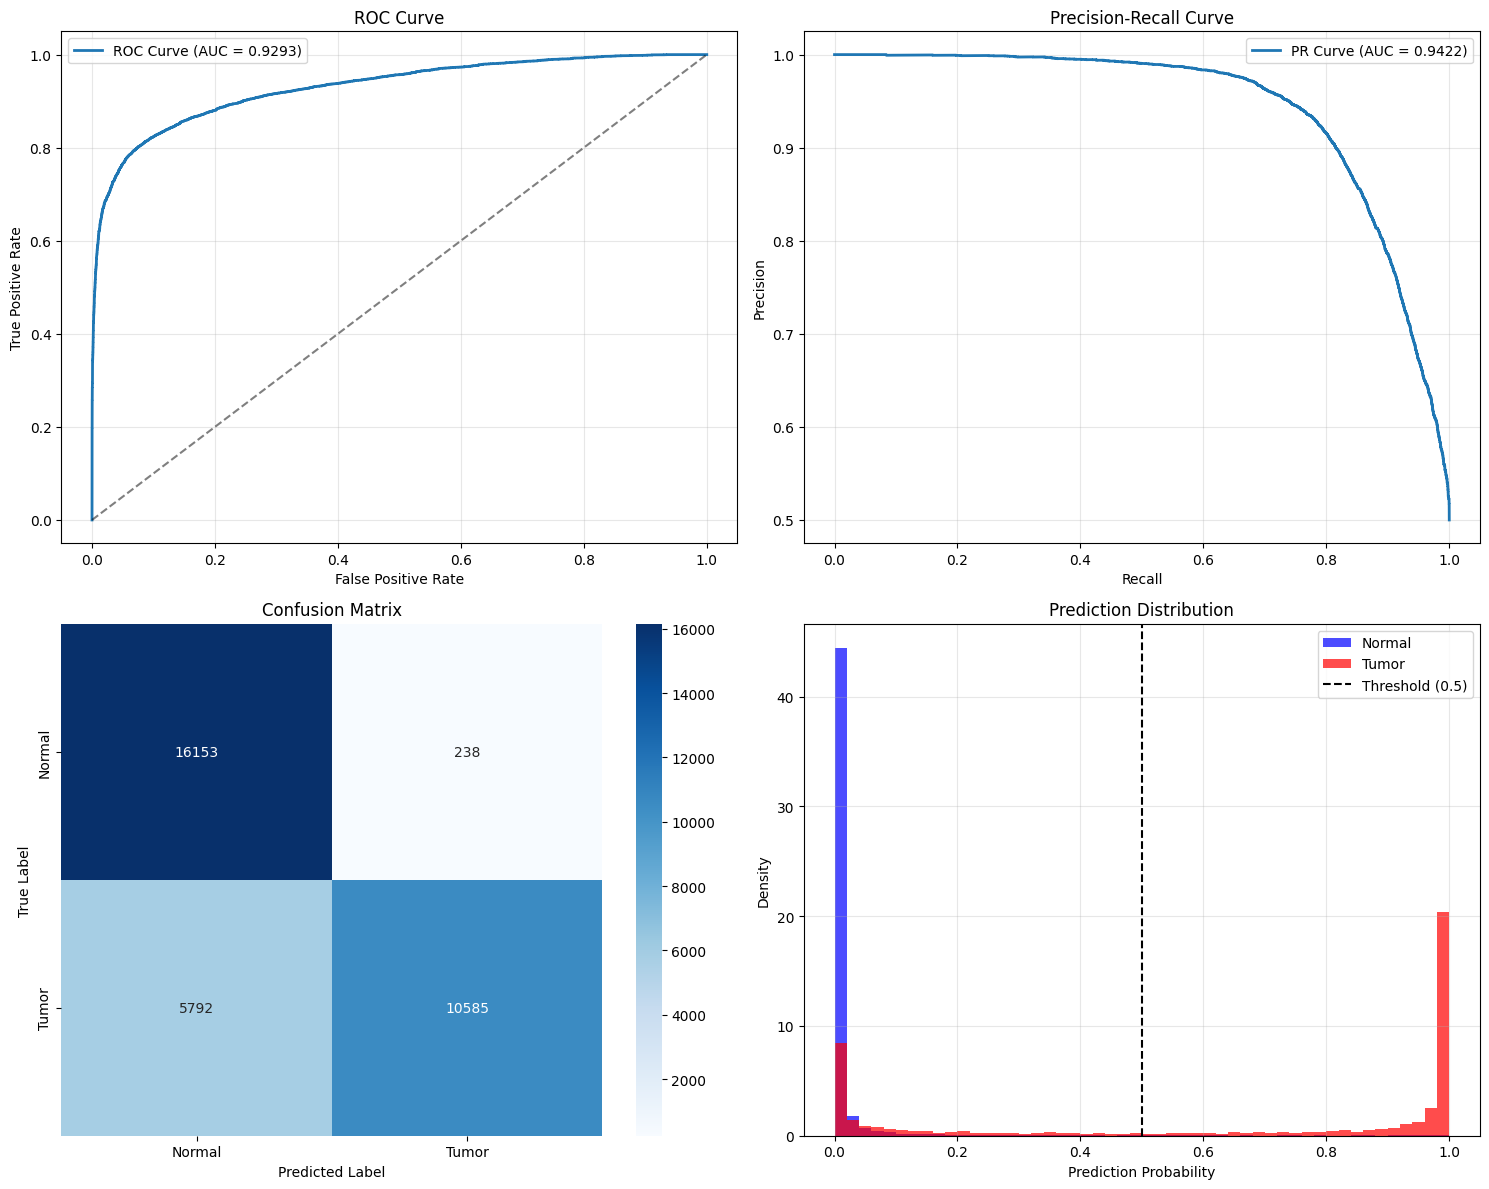

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import h5py
import numpy as np
import pandas as pd
import time
from sklearn.metrics import (roc_auc_score, average_precision_score, 
                             accuracy_score, f1_score, classification_report, 
                             confusion_matrix, roc_curve, precision_recall_curve)
import types

# -------------------------------
# GeM pooling
# -------------------------------
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        x = torch.clamp(x, min=self.eps)
        x = torch.pow(x, self.p)
        x = F.avg_pool2d(x, kernel_size=(x.size(-2), x.size(-1)))
        x = torch.pow(x + self.eps, 1.0 / self.p)
        return x

# -------------------------------
# Load Trained Model with GeM
# -------------------------------
cfg_model = cfg["model"]

if cfg_model["backbone"] == "densenet121":
    model = models.densenet121(weights=None)
    num_features = model.classifier.in_features
    model.gem = GeM()
    model.classifier = nn.Sequential(
        nn.Dropout(cfg_model["dropout"]),
        nn.Linear(num_features, 1)
    )
    for m in model.modules():
        if isinstance(m, nn.ReLU):
            m.inplace = False
    def forward_with_gem(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=False)
        out = self.gem(out)
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out
    model.forward = types.MethodType(forward_with_gem, model)
else:
    raise NotImplementedError(f"Backbone {cfg_model['backbone']} not implemented")

# Load trained weights
model_path = "densenet121_chunked.pth"
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    print(f"✅ Model loaded from {model_path}")
except FileNotFoundError:
    print(f"❌ Model file {model_path} not found. Please train the model first.")
    exit()

model = model.to(device)
model.eval()

# -------------------------------
# Test Dataset
# -------------------------------
cfg_data = cfg["data"]
test_transform = transforms.Compose([
    transforms.Resize((cfg_data["img_size"], cfg_data["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=cfg_data["normalize"]["mean"], 
                         std=cfg_data["normalize"]["std"])
])

class PCamDatasetChunk(Dataset):
    def __init__(self, h5_path, labels_path=None, transform=None, start_idx=0, end_idx=None):
        self.h5_file = h5py.File(h5_path, "r")
        key = "x" if "x" in self.h5_file else list(self.h5_file.keys())[0]
        if end_idx is None:
            end_idx = len(self.h5_file[key])
        self.images = self.h5_file[key][start_idx:end_idx]
        self.transform = transform
        self.length = end_idx - start_idx
        self.labels = None
        if labels_path is not None:
            with h5py.File(labels_path, "r") as f:
                self.labels = f["y"][start_idx:end_idx]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        if self.transform:
            img = self.transform(img)
        if self.labels is not None:
            return img, int(self.labels[idx])
        else:
            return img

    def close(self):
        if hasattr(self, 'h5_file') and self.h5_file:
            self.h5_file.close()

h5_test_x = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_test_x.h5"
h5_test_y = "/kaggle/input/pcamv1/pcamv1/camelyonpatch_level_2_split_test_y.h5"
test_dataset = PCamDatasetChunk(h5_test_x, labels_path=h5_test_y, transform=test_transform)

cfg_loader = cfg["loader"]
test_loader = DataLoader(
    test_dataset, 
    batch_size=cfg_loader["batch_size"], 
    shuffle=False, 
    num_workers=cfg_loader["num_workers"], 
    pin_memory=cfg_loader["pin_memory"]
)

# -------------------------------
# Test Evaluation
# -------------------------------
decision_threshold = cfg["objective"]["decision_threshold"]
criterion = nn.BCEWithLogitsLoss()

all_preds, all_labels, all_probabilities = [], [], []
test_loss = 0.0
start_time = time.time()

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device, non_blocking=True)
        labels = labels.float().unsqueeze(1).to(device, non_blocking=True)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > decision_threshold).astype(int)
        all_probabilities.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.cpu().numpy())
        if batch_idx % 100 == 0:
            print(f"Processed batch {batch_idx}/{len(test_loader)}")

test_loss /= len(test_dataset)
all_probabilities = np.vstack(all_probabilities)
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)
evaluation_time = time.time() - start_time

# -------------------------------
# Metrics
# -------------------------------
roc_auc = roc_auc_score(all_labels, all_probabilities)
pr_auc = average_precision_score(all_labels, all_probabilities)
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

cm = confusion_matrix(all_labels.flatten(), all_preds.flatten())
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\nTest Loss : {test_loss:.4f}")
print(f"ROC-AUC   : {roc_auc:.4f}")
print(f"PR-AUC    : {pr_auc:.4f}")
print(f"Accuracy  : {accuracy:.4f}")
print(f"F1-Score  : {f1:.4f}")
print(f"Sensitivity (Recall) : {sensitivity:.4f}")
print(f"Specificity          : {specificity:.4f}")
print(f"Precision (PPV)      : {precision:.4f}")
print(f"Negative Pred. Value : {npv:.4f}")

print("\nClassification Report:")
print(classification_report(all_labels.flatten(), all_preds.flatten(), 
                            target_names=['Normal','Tumor'], digits=4))

# -------------------------------
# Save Results
# -------------------------------
test_results = {
    'test_loss': test_loss,
    'roc_auc': roc_auc,
    'pr_auc': pr_auc,
    'accuracy': accuracy,
    'f1_score': f1,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'precision': precision,
    'negative_predictive_value': npv,
    'true_negatives': int(tn),
    'false_positives': int(fp),
    'false_negatives': int(fn),
    'true_positives': int(tp),
    'decision_threshold': decision_threshold,
    'evaluation_time_seconds': evaluation_time
}

import json
with open('test_results.json', 'w') as f:
    json.dump(test_results, f, indent=2)

predictions_df = pd.DataFrame({
    'sample_id': range(len(all_labels)),
    'true_label': all_labels.flatten(),
    'probability': all_probabilities.flatten(),
    'prediction': all_preds.flatten(),
    'correct': (all_labels.flatten() == all_preds.flatten()).astype(int)
})
predictions_df.to_csv('test_predictions.csv', index=False)

# -------------------------------
# Visualizations
# -------------------------------
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probabilities)
    axes[0,0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', linewidth=2)
    axes[0,0].plot([0,1],[0,1],'k--', alpha=0.5)
    axes[0,0].set_xlabel('False Positive Rate')
    axes[0,0].set_ylabel('True Positive Rate')
    axes[0,0].set_title('ROC Curve')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # PR Curve
    precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_probabilities)
    axes[0,1].plot(recall_curve, precision_curve, label=f'PR Curve (AUC = {pr_auc:.4f})', linewidth=2)
    axes[0,1].set_xlabel('Recall')
    axes[0,1].set_ylabel('Precision')
    axes[0,1].set_title('Precision-Recall Curve')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal','Tumor'], yticklabels=['Normal','Tumor'], ax=axes[1,0])
    axes[1,0].set_title('Confusion Matrix')
    axes[1,0].set_ylabel('True Label')
    axes[1,0].set_xlabel('Predicted Label')

    # Prediction Distribution
    axes[1,1].hist(all_probabilities[all_labels.flatten()==0], bins=50, alpha=0.7, 
                   label='Normal', color='blue', density=True)
    axes[1,1].hist(all_probabilities[all_labels.flatten()==1], bins=50, alpha=0.7, 
                   label='Tumor', color='red', density=True)
    axes[1,1].axvline(decision_threshold, color='black', linestyle='--', 
                      label=f'Threshold ({decision_threshold})')
    axes[1,1].set_xlabel('Prediction Probability')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Prediction Distribution')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('test_evaluation_plots.png', dpi=300, bbox_inches='tight')
    print("✅ Visualization saved to test_evaluation_plots.png")

except ImportError:
    print("Note: matplotlib/seaborn not available for plotting")

# Cleanup
test_dataset.close()
print("\n✅ Test evaluation complete!")
